## Reference
1) Approach: https://towardsdatascience.com/building-a-book-recommendation-system-using-keras-1fba34180699  
2) Implicit Rating Normalization: https://www.cs.purdue.edu/homes/lsi/sigir04-cf-norm.pdf  
3) Adding dense layers: https://nipunbatra.github.io/blog/2017/recommend-keras.html  
4) Scaling columns in pandas: https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/  
5) Keras documentation: https://keras.io/  

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import random
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input, Embedding, Dot, GRU, LSTM, Dense, Flatten, Concatenate, Dropout 
from keras.callbacks import EarlyStopping, ModelCheckpoint

/Users/dima/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/Users/dima/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read all the files

data_folder = "input_data/"
proc_data_folder = "processed_data/"


aisles = pd.read_csv(os.path.join(data_folder, "aisles.csv"))
departments = pd.read_csv(os.path.join(data_folder, "departments.csv"))
products = pd.read_csv(os.path.join(data_folder, "products.csv"))


# Sample from the big files for now
order_prod_prior = pd.read_csv(os.path.join(data_folder, "order_products__prior.csv"))
order_prod_train = pd.read_csv(os.path.join(data_folder, "order_products__train.csv"))
orders = pd.read_csv(os.path.join(data_folder, "orders.csv"))


In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
order_prod_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [133]:
# Sample n users' orders,

random.seed(2018)

samples = 10000
all_user_ids = set(orders["user_id"].unique())
sampled_user_ids = sorted(random.sample(all_user_ids,samples))

order_samp = orders[orders["user_id"].isin(sampled_user_ids)]

In [134]:
# Add products in these orders
data_samp = (order_samp.merge(order_prod_prior, on="order_id")
             .append(order_samp.merge(order_prod_train, on="order_id")))

# Add aisle and department ids 
data_samp = data_samp.merge(products, on="product_id", how="inner")

# Fill missing data
data_samp["days_since_prior_order"] = data_samp["days_since_prior_order"].fillna(0) 

In [135]:
# Fill missing data
data_samp["days_since_prior_order"] = data_samp["days_since_prior_order"].fillna(0) 

data_samp.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,611214,24,prior,1,3,20,0.0,31222,1,0,"100% Juice, Variety Pack",98,7
1,1511050,24,prior,3,3,21,30.0,31222,1,1,"100% Juice, Variety Pack",98,7
2,118133,24,prior,5,0,11,30.0,31222,1,1,"100% Juice, Variety Pack",98,7
3,3064712,24,prior,8,1,20,8.0,31222,2,1,"100% Juice, Variety Pack",98,7
4,3320181,24,prior,11,4,14,6.0,31222,1,1,"100% Juice, Variety Pack",98,7


### Feature engineering
1) Provide new Provide new monotonically increasing indices for each categorical feature  
2) Scale "days since prior order", "order number"  

In [136]:
# Generate vocabulary for all available levels of each categorical feature
# Provide new monotonically increasing indices for each starting at 0

user_vocab = sorted(data_samp.user_id.unique())
user_vocab_size = len(user_vocab)
user_id_idx = dict(zip(user_vocab,range(user_vocab_size)))
data_samp["new_user_id"] = data_samp["user_id"].apply(lambda x: user_id_idx[x])


product_vocab = sorted(data_samp.product_id.unique())
product_vocab_size = len(product_vocab)
prod_id_idx = dict(zip(product_vocab,range(product_vocab_size)))
data_samp["new_product_id"] = data_samp["product_id"].apply(lambda x: prod_id_idx[x])


aisle_vocab = data_samp.aisle_id.unique()
aisle_vocab_size = len(aisle_vocab)
aisle_id_idx = dict(zip(aisle_vocab,range(aisle_vocab_size)))
data_samp["new_aisle_id"] = data_samp["aisle_id"].apply(lambda x: aisle_id_idx[x])

dept_vocab = data_samp.department_id.unique()
dept_vocab_size = len(dept_vocab)
dept_id_idx = dict(zip(dept_vocab,range(dept_vocab_size)))
data_samp["new_department_id"] = data_samp["department_id"].apply(lambda x: dept_id_idx[x])

In [137]:
# Scale relevant numeric features
from sklearn import preprocessing

col_names = ["days_since_prior_order","order_number"]

# Create subset for scaling
x = data_samp[col_names].values.astype(float)

# Create a scaler and apply it
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
df_normalized.columns = col_names
# df_normalized.head()

# Add back to the original DF

data_samp[col_names] = df_normalized

In [138]:
data_samp.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,new_user_id,new_product_id,new_aisle_id,new_department_id
0,611214,24,prior,-0.918500,3,20,-1.178444,31222,1,0,"100% Juice, Variety Pack",98,7,0,22509,0,0
1,1511050,24,prior,-0.805098,3,21,2.115236,31222,1,1,"100% Juice, Variety Pack",98,7,0,22509,0,0
2,118133,24,prior,-0.691695,0,11,2.115236,31222,1,1,"100% Juice, Variety Pack",98,7,0,22509,0,0
3,3064712,24,prior,-0.521592,1,20,-0.300130,31222,2,1,"100% Juice, Variety Pack",98,7,0,22509,0,0
4,3320181,24,prior,-0.351488,4,14,-0.519708,31222,1,1,"100% Juice, Variety Pack",98,7,0,22509,0,0


In [139]:
print("Unique users: {}, products: {}, aisles: {}, departments: {}"
      .format(user_vocab_size, product_vocab_size,aisle_vocab_size,dept_vocab_size))

Unique users: 10000, products: 35886, aisles: 134, departments: 21


### Split into train and test

In [140]:
train_subset = data_samp[data_samp["eval_set"]=="prior"]
target_subset = data_samp[data_samp["eval_set"]=="train"]

In [141]:
print(train_subset.shape, target_subset.shape)

(1592914, 17) (68162, 17)


In [142]:
train_subset.to_csv("processed_data/nn_train_subset.csv", index=False)
target_subset.to_csv("processed_data/nn_target_subset.csv", index=False)

### Build model

We build a neural network 1 with the following inputs:  
1) 3 categorical features are projected to embedding layers  
2) Integer features are consumed as is  
3) Information on the order_id is not used  

In [116]:
cat_columns = ["user_id","product_id","aisle_id","department_id"]
num_columns = ["order_number", "order_dow","order_hour_of_day","days_since_prior_order","add_to_cart_order"]

In [117]:
train_subset.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'new_user_id', 'new_product_id', 'new_aisle_id',
       'new_department_id'],
      dtype='object')

In [118]:
latent_dim_user = 10
latent_dim_product = 20
latent_dim_aisle = 10
latent_dim_dept = 5


user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(user_vocab_size, latent_dim_user, name="User-Embedding")(user_input)  
user_vec = Flatten(name="Flatten-Users")(user_embedding) # make a vector for the concat

prod_input = Input(shape=[1], name="Product-Input")
prod_embedding = Embedding(product_vocab_size, latent_dim_product, name="Product-Embedding")(prod_input)  
# dropout_0 = Dropout(0.5,name='Dropout-0')(prod_embedding)
prod_vec = Flatten(name="Flatten-Products")(prod_embedding) # make a vector for the concat

aisle_input = Input(shape=[1], name="Aisle-Input")
aisle_embedding = Embedding(aisle_vocab_size, latent_dim_aisle, name="Aisle-Embedding")(aisle_input)
aisle_vec = Flatten(name="Flatten-Aisles")(aisle_embedding) # make a vector for the concat

dept_input = Input(shape=[1], name="Dept-Input")
dept_embedding = Embedding(aisle_vocab_size, latent_dim_aisle, name="Dept-Embedding")(dept_input)
dept_vec = Flatten(name="Flatten-Depts")(dept_embedding) # make a vector for the concat

num_input = Input(shape=[5], name="Numeric-Input")

concat = Concatenate()([user_vec, prod_vec, aisle_vec, dept_vec, num_input])

dense_1 = Dense(55,name='FullyConnected-1',activation='relu')(concat)
dropout_1 = Dropout(0.5,name='Dropout-1')(dense_1)

dense_2 = Dense(20,name='FullyConnected-2',activation='relu')(dropout_1)
dropout_2 = Dropout(0.5,name='Dropout-2')(dense_2)

# dense_3 = Dense(10,name='FullyConnected-3',activation='relu')(dropout_2)
# dropout_3 = Dropout(0.5,name='Dropout-3')(dense_3)

output = Dense(1,name='FullyConnected-Output', activation='sigmoid')(dropout_2)

model = Model([user_input, prod_input, aisle_input, dept_input, num_input], output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [119]:
# del model

In [120]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Product-Input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
Aisle-Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
Dept-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
User-Embed

In [121]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


history = model.fit([train_subset.new_user_id, train_subset.new_product_id, 
                     train_subset.new_aisle_id, train_subset.new_department_id,
                    train_subset[num_columns]], 
                    train_subset.reordered,
                    callbacks=callbacks,
                    validation_split = 0.1,
                    batch_size=1000,
                    epochs=20, verbose=1)
model.save('classification_model.h5')

Train on 568422 samples, validate on 63159 samples
Epoch 1/20
568422/568422 [==============================] - 7s 12us/step - loss: 0.6770 - acc: 0.6380 - val_loss: 0.5852 - val_acc: 0.7136
Epoch 2/20
568422/568422 [==============================] - 6s 10us/step - loss: 0.5375 - acc: 0.7417 - val_loss: 0.5526 - val_acc: 0.7189
Epoch 3/20
568422/568422 [==============================] - 6s 10us/step - loss: 0.5096 - acc: 0.7588 - val_loss: 0.5435 - val_acc: 0.7220
Epoch 4/20
568422/568422 [==============================] - 6s 10us/step - loss: 0.4933 - acc: 0.7671 - val_loss: 0.5382 - val_acc: 0.7230
Epoch 5/20
568422/568422 [==============================] - 6s 10us/step - loss: 0.4810 - acc: 0.7736 - val_loss: 0.5342 - val_acc: 0.7256
Epoch 6/20
568422/568422 [==============================] - 6s 10us/step - loss: 0.4717 - acc: 0.7781 - val_loss: 0.5370 - val_acc: 0.7255
Epoch 7/20
568422/568422 [==============================] - 6s 10us/step - loss: 0.4655 - acc: 0.7809 - val_loss: 0

Text(0, 0.5, 'Train Error')

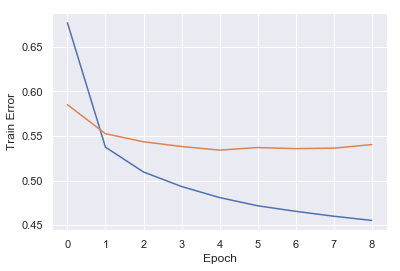

In [122]:
%matplotlib inline

pd.Series(history.history['loss']).plot()
pd.Series(history.history['val_loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In seems that the model starts to overfit already in the first training epochs

In [123]:
# Extract embeddings for users
user_em = model.get_layer('User-Embedding')
user_em_weights = user_em.get_weights()[0]

# Extract embeddings for products
prod_em = model.get_layer('Product-Embedding')
prod_em_weights = prod_em.get_weights()[0]

# Extract embeddings for aisles
aisle_em = model.get_layer('Aisle-Embedding')
aisle_em_weights = aisle_em.get_weights()[0]

# Extract embeddings for departments
dept_em = model.get_layer('Dept-Embedding')
dept_em_weights = dept_em.get_weights()[0]

Each product id has received *n* coordinates in the product embedding space (correspondent to latent_dim parameter)  
Each department has received *m* coordinates in the user embedding space

In [124]:
print(user_em_weights.shape, prod_em_weights.shape, aisle_em_weights.shape, dept_em_weights.shape)

(4000, 10) (27382, 20) (134, 10) (134, 10)


Is there any structure in this space - are the products somehow separated from each other?

Text(0.5, 1.0, 'PCA: Department Embeddings')

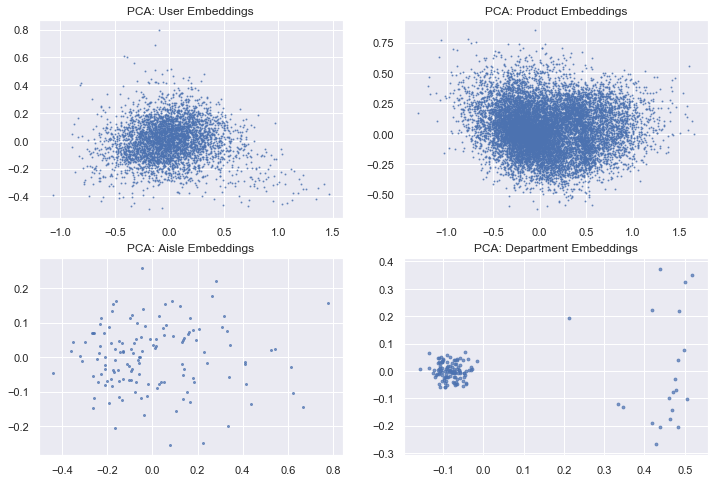

In [125]:
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

user_pca_result = pca.fit_transform(user_em_weights)
prod_pca_result = pca.fit_transform(prod_em_weights)
aisle_pca_result = pca.fit_transform(aisle_em_weights)
dept_pca_result = pca.fit_transform(dept_em_weights)

# prepare image and figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize = (12,8))

ax1.scatter(x=user_pca_result[:,0], y=user_pca_result[:,1],alpha=0.7,s=1)
ax1.set_title("PCA: User Embeddings")
ax2.scatter(x=prod_pca_result[:,0], y=prod_pca_result[:,1],alpha=0.7,s=1)
ax2.set_title("PCA: Product Embeddings")
ax3.scatter(x=aisle_pca_result[:,0], y=aisle_pca_result[:,1],alpha=0.7,s=4)
ax3.set_title("PCA: Aisle Embeddings")
ax4.scatter(x=dept_pca_result[:,0], y=dept_pca_result[:,1],alpha=0.7,s=8)
ax4.set_title("PCA: Department Embeddings")



There is a clear structure that separates products, and it is more complex than 2 dimensions

For users, it also looks like both dimensions show distances between departments that are sufficient to identify clusters

### Evaluate the model


In [126]:
predictions = model.predict([target_subset.new_user_id,target_subset.new_product_id, 
                             target_subset.new_aisle_id, target_subset.new_department_id,
                             target_subset[num_columns]])

In [127]:
out = target_subset
out["pred_prob"] = predictions

thresh = 0.5

out.loc[out["pred_prob"]>thresh,"pred_label"] = 1
out.loc[out["pred_prob"]<=thresh,"pred_label"] = 0
# out.head(10)

/Users/dima/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dima/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dima/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

count    2.703700e+04
mean     5.724003e-01
std      2.857165e-01
min      5.027156e-12
25%      3.456322e-01
50%      6.251009e-01
75%      8.136254e-01
max      9.995782e-01
Name: pred_prob, dtype: float64

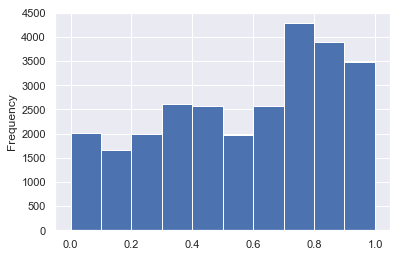

In [128]:
out.pred_prob.plot.hist()
out.pred_prob.describe()

In [129]:
y_test = out["reordered"]
predictions = out["pred_label"]

acc_baseline = y_test.reset_index().groupby("reordered").count()
acc_baseline["class_share"] = acc_baseline["index"]/ acc_baseline["index"].sum()
acc_baseline["class_share"].max()

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("vs. baseline {:.2%}".format(acc_baseline["class_share"].max().astype("float")))

Accuracy: 70.58%
vs. baseline 60.21%


In [130]:
%run plot_confusion_matrix.py

<Figure size 432x288 with 0 Axes>

Normalized confusion matrix


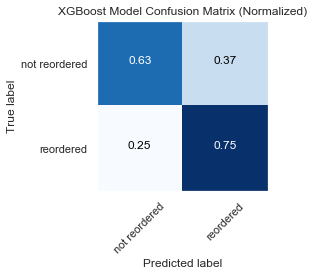

In [131]:
class_names = ["not reordered", "reordered"]
cnf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.grid(False)
fig = plot_confusion_matrix(cnf_matrix, classes=class_names,
                            normalize=True,
                            title='XGBoost Model Confusion Matrix (Normalized)')
# fig.rcParams['figure.figsize'] = [5, 5]

In [132]:
f1_score(y_true=y_test, y_pred=predictions)

0.7549366932626845

## Model description

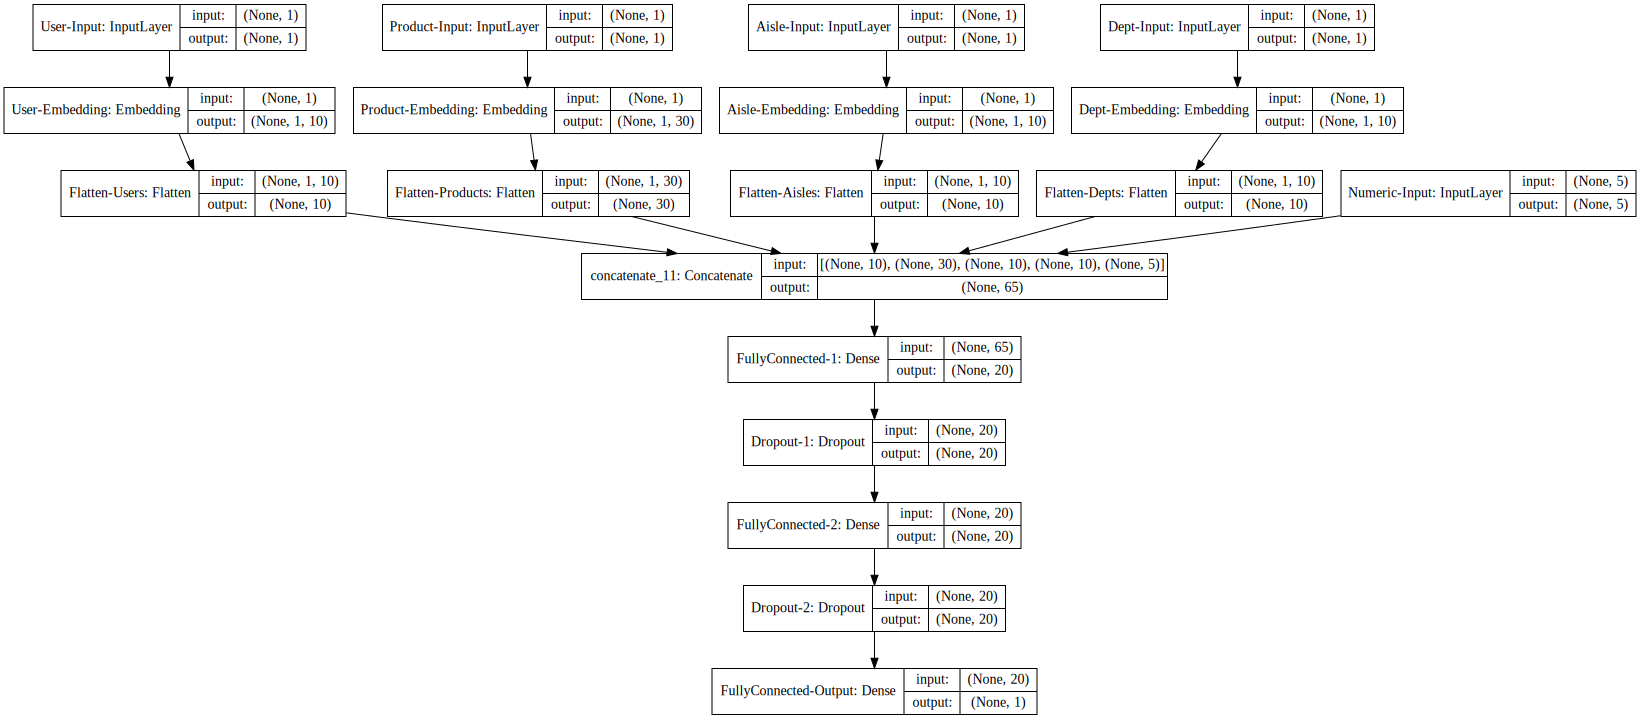

In [246]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))